In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
POSTGRES = {

'user' : 'postgres',
'pw' : 'admin',
'host' : 'localhost',
'port' : '5432',
'db' : 'options'
}

In [3]:
class Config(object):
    # ...
    SQLALCHEMY_DATABASE_URI =  os.environ.get('DATABASE_URL') or 'postgresql://%(user)s:%(pw)s@%(host)s:%(port)s/%(db)s' % POSTGRES
    SQLALCHEMY_TRACK_MODIFICATIONS = False

config = Config()

cnx = create_engine(config.SQLALCHEMY_DATABASE_URI)

In [15]:
df = pd.read_sql_query("select * from chains", cnx)

In [31]:
df['short_asof_date'] = df['asof_date'].apply(lambda x: x.date().strftime('%Y-%m-%d'))

In [37]:
dfLastDate = df[df['short_asof_date'] == df['short_asof_date'].iloc[-1]]

In [39]:
dfLastDate.expiry.unique()

array(['2021-12-31T00:00:00.000000000', '2022-01-03T00:00:00.000000000',
       '2022-01-05T00:00:00.000000000', '2022-01-07T00:00:00.000000000',
       '2022-01-10T00:00:00.000000000', '2022-01-12T00:00:00.000000000',
       '2022-01-14T00:00:00.000000000', '2022-01-18T00:00:00.000000000',
       '2022-01-19T00:00:00.000000000', '2022-01-21T00:00:00.000000000',
       '2022-01-24T00:00:00.000000000', '2022-01-26T00:00:00.000000000',
       '2022-01-28T00:00:00.000000000', '2022-01-31T00:00:00.000000000',
       '2022-02-02T00:00:00.000000000', '2022-02-04T00:00:00.000000000',
       '2022-02-11T00:00:00.000000000', '2022-02-18T00:00:00.000000000',
       '2022-03-18T00:00:00.000000000', '2022-03-31T00:00:00.000000000',
       '2022-04-14T00:00:00.000000000', '2022-05-20T00:00:00.000000000',
       '2022-06-17T00:00:00.000000000', '2022-06-30T00:00:00.000000000',
       '2022-09-16T00:00:00.000000000', '2022-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [40]:
calls = dfLastDate[dfLastDate['type'] == 'Call']
puts = dfLastDate[dfLastDate['type'] == 'Put']

In [44]:
expiry = '2022-01-03'
calls_expiry = calls[calls['expiry']==expiry]

In [45]:
calls_expiry

,asof_date,strike,last,theor,delta,gamma,iv,theta,vega,rho,vol_oi,volume,open_int,type,last_trade,expiry,short_asof_date
5211,2021-12-30 17:11:40,459.0,19.92,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.04,20,521,Call,2021-12-30 10:18:00,2022-01-03,2021-12-30
5212,2021-12-30 17:11:40,461.0,17.68,17.92,0.98958,0.00346,0.1652,-0.02351,0.01344,0.01471,0.01,9,778,Call,2021-12-30 10:08:00,2022-01-03,2021-12-30
5213,2021-12-30 17:11:40,462.0,15.82,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00,0,1927,Call,2021-12-29 00:00:00,2022-01-03,2021-12-30
5214,2021-12-30 17:11:40,463.0,14.15,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00,0,1892,Call,2021-12-29 00:00:00,2022-01-03,2021-12-30
5215,2021-12-30 17:11:40,464.0,15.08,14.93,0.98200,0.00613,0.1489,-0.03513,0.02177,0.01884,0.00,7,2192,Call,2021-12-30 10:27:00,2022-01-03,2021-12-30
5216,2021-12-30 17:11:40,465.0,13.74,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00,4,4447,Call,2021-12-30 10:09:00,2022-01-03,2021-12-30
5217,2021-12-30 17:11:40,466.0,13.11,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00,7,3789,Call,2021-12-30 10:27:00,2022-01-03,2021-12-30
5218,2021-12-30 17:11:40,467.0,11.31,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00,3,2403,Call,2021-12-30 10:03:00,2022-01-03,2021-12-30
5219,2021-12-30 17:11:40,468.0,10.77,10.99,0.95640,0.01442,0.1308,-0.06771,0.04598,0.02616,0.02,39,1930,Call,2021-12-30 10:08:00,2022-01-03,2021-12-30
5220,2021-12-30 17:11:40,469.0,9.85,0.00,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.01,23,1831,Call,2021-12-30 10:14:00,2022-01-03,2021-12-30


In [49]:
print(calls_expiry['volume'].mean(),calls_expiry['volume'].std()) 

950.2820512820513 1841.4597177342187


<AxesSubplot:xlabel='strike', ylabel='iv'>

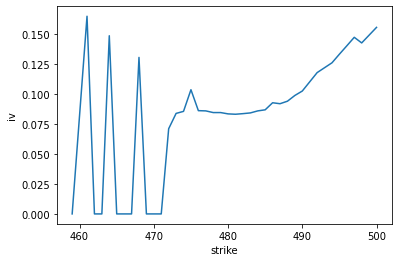

In [47]:

sns.lineplot(data=calls_expiry, x='strike', y='iv')